## Imports

In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *

## Constants

In [9]:
#CONSTANT

pyt_comma = 0.0136432
peaks = [2.4, 6.5, 11.4, 18.8, 29, 33.6]
round_peaks = [int(i) for i in peaks]

#planet ratios
Schumann_earth = [7.83, 14.3, 20.8, 27.3, 33.8]
Mercury = 141.27

## Functions

### Utilities

In [11]:
a, b, c = compareLists([4, 4.8, 5.8], [5.8, 4, 8, 10], 0.1)
a

array([4. , 5.8])

### Peak ratios and Harmonics

In [31]:
peak_ratios, peak_ratios_bound = compute_peak_ratios(peaks)
peak_ratios_bound

[1.0434782608695652,
 1.0671641791044777,
 1.243243243243243,
 1.2972972972972971,
 1.3333333333333335,
 1.3426573426573425,
 1.373134328358209,
 1.3913043478260871,
 1.3958333333333335,
 1.4328358208955223,
 1.4895833333333335,
 1.5416666666666667,
 1.5543478260869568,
 1.7297297297297298,
 1.7902097902097902,
 1.8108108108108107,
 1.9104477611940298,
 1.9166666666666665,
 1.9324324324324325,
 2.0]

In [6]:


###TO DO###
#This function computes harmonics of a list of peaks and compares the lists of harmonics pairwise to find consonant ratios
#between different harmonic series
def harmonic_consonance_fit(peaks, n_harm = 10, bounds = 1, function = 'mult'):
    from itertools import combinations
    peak_bands = []
    for i in range(len(peaks)):
        peak_bands.append(i)
    if function == 'mult':
        multi_harmonics = EEG_harmonics_mult(peaks, n_harm)
    elif function == 'div':
        multi_harmonics, x, y, z = EEG_harmonics_div(peaks, n_harm)
    #print(multi_harmonics)
    list_peaks = list(combinations(peak_bands,2))
    print(list_peaks)
    harm_temp = []
    for i in range(len(list_peaks)):
        harms, b, c = compareLists(multi_harmonics[list_peaks[i][0]], multi_harmonics[list_peaks[i][1]], bounds)  
        harm_temp.append(harms)
    harm_fit = np.array(harm_temp).squeeze()

    if len(peak_bands) > 2:
        harm_fit = list(itertools.chain.from_iterable(harm_fit))

    return harm_fit

In [65]:
peaks = [1.3,  4.8,  8.9, 15.2, 23.4, 34.2, 49.4]
test = harmonic_fit(peaks = peaks, n_harm = 15, bounds = 0.1)
test

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


[14.35, 62.35, 136.8, 197.6, 444.6]

In [29]:
peaks = [2.4, 3.7, 6.7, 9.2, 14.3, 19.2, 25.6]
harmonic_fitting = harmonic_fit(75, 0.05, 'mult')
harmonic_fitting


[156.0,
 45.6,
 91.2,
 136.8,
 182.4,
 112.80000000000001,
 33.6,
 67.2,
 100.80000000000001,
 134.4,
 168.0,
 377.0,
 638.4]

In [17]:
h, i = compute_peak_ratios(peaks, 1, 2)
i

[1.0434782608695652,
 1.0671641791044777,
 1.243243243243243,
 1.2972972972972971,
 1.3333333333333335,
 1.3426573426573425,
 1.373134328358209,
 1.3913043478260871,
 1.3958333333333335,
 1.4328358208955223,
 1.4895833333333335,
 1.5416666666666667,
 1.5543478260869568,
 1.7297297297297298,
 1.7902097902097902,
 1.8108108108108107,
 1.9104477611940298,
 1.9166666666666665,
 1.9324324324324325,
 2.0]

In [18]:
peaks = [2.3, 4.7, 9.9, 13, 19.2, 33, 45.3]
z, charm_fit = compute_peak_ratios(harmonic_fit(33, 0.1, 'mult', peaks))
charm_fit

[1.0833333333333333,
 1.267605633802817,
 1.3732394366197185,
 1.4444444444444444,
 1.5,
 1.9014084507042255,
 2.0]

In [19]:
mh, mh_bound, mh_sub, mh_sub_bound = EEG_harmonics_div(peaks, 10, n_oct_up = 0)
mh
#div_harmonics = compareLists(mh[5], mh[4], 0.01)
#div_harmonics

array([[  3.45      ,   4.21666667,   4.79166667,   5.25166667,
          5.635     ,   5.96357143,   6.25107143,   6.50662698,
          6.73662698,   6.94571789],
       [  7.05      ,   8.61666667,   9.79166667,  10.73166667,
         11.515     ,  12.18642857,  12.77392857,  13.29615079,
         13.76615079,  14.19342352],
       [ 14.85      ,  18.15      ,  20.625     ,  22.605     ,
         24.255     ,  25.66928571,  26.90678571,  28.00678571,
         28.99678571,  29.89678571],
       [ 19.5       ,  23.83333333,  27.08333333,  29.68333333,
         31.85      ,  33.70714286,  35.33214286,  36.7765873 ,
         38.0765873 ,  39.25840548],
       [ 28.8       ,  35.2       ,  40.        ,  43.84      ,
         47.04      ,  49.78285714,  52.18285714,  54.31619048,
         56.23619048,  57.98164502],
       [ 49.5       ,  60.5       ,  68.75      ,  75.35      ,
         80.85      ,  85.56428571,  89.68928571,  93.35595238,
         96.65595238,  99.65595238],
       [ 6

In [20]:
#Compute peaks interval of consonant harmonics
#conson, cons_values = compute_consonance ((harmonic_fit(50, 0.1, 'mult')), 0.2)
#cons_values

#Finds the best octave subdivisions for the harmonic spectrum of the peaks list
peaks = [42.5, 5.5, 8.3, 1.5, 19.5, 10, 32.4]
max_sub = 200
octave_limit = 0.01

peaks_harmonics = harmonic_fit(50, 0.05, 'mult')

oct_div_final, ratios = multi_oct_subdiv(peaks_harmonics, max_sub, octave_limit)
oct_div_final, ratios


NameError: name 'multi_oct_subdiv' is not defined

### n-TET 

In [28]:
peaks = [42.5, 5.2, 7.8, 1.5, 19.4, 9.6, 32.4]
max_sub = 120
octave_limit = 0.05

oct_div_final, ratios = multi_oct_subdiv(peaks, max_sub, octave_limit)
oct_div_final, ratios

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


([12, 53, 65, 90, 106, 110, 118], [1.5, 1.625, 1.25, 1.6875])

### Consonance

In [34]:

a, b = compute_consonance(peaks + Schumann_earth, 0.1)
c, d = comp_consonant_integers_ratios (b)
print(sorted(d))
#print(d)



[1.3125, 1.375, 1.421875, 1.625]


### Tunings

In [26]:
# Function that computes Pythogorian Tunings from integer ratios 
# List of equations of the Pythagorean Tuning
# variable 'a' has to be the highest value in the ratio

#INPUTS (a: numerator of the source ratio / b: denominator of the source ratio
#        n: multiplifier of all notes / octa: octave value / lim_denom: highest value possible
#        for the denominator of the ratios)
#OUTPUTS

def compute_pythagore(a = 3, b = 2, n = 1, octa = 2, lim_denom = 1000):
    import operator
    pyth0 = n * (1/1)
    pyth1 = n * ((b/a)**5)*(octa**3)
    pyth1 = rebound(pyth1, 1, octa)
    pyth2 = n * ((a/b)**2)*(1/octa)
    pyth2 = rebound(pyth2, 1, octa)
    pyth3 = n * ((b/a)**3)*(octa**2)
    pyth3 = rebound(pyth3, 1, octa)
    pyth4 = n * ((a/b)**4)*((1/octa)**2)
    pyth4 = rebound(pyth4, 1, octa)
    pyth5 = n * (b/a)*octa
    pyth5 = rebound(pyth5, 1, octa)
    pyth6 = n * ((b/a)**6)*(octa**4)
    pyth6 = rebound(pyth6, 1, octa)
    pyth6_2 = n * ((a/b)**6)*((1/octa)**3)
    pyth6_2 = rebound(pyth6_2, 1, octa)
    pyth7 = n * (a/b)
    pyth7 = rebound(pyth7, 1, octa)
    pyth8 = n * ((b/a)**4)*(octa**3)
    pyth8 = rebound(pyth8, 1, octa)
    pyth9 = n * ((a/b)**3)*(1/octa)
    pyth9 = rebound(pyth9, 1, octa)
    pyth10 = n * ((b/a)**2)*(octa**2)
    pyth10 = rebound(pyth10, 1, octa)
    pyth11 = n * ((a/b)**5)*((1/octa)**2)
    pyth11 = rebound(pyth11, 1, octa)
    pyth12 = rebound((n * octa), 1, octa)
    
    pyth_dict = {'unison':pyth0,
             'minor second':pyth1,
             'major second':pyth2,
             'minor third':pyth3,
             'major third':pyth4,
             'perfect fourth':pyth5,
             'diminished fifth':pyth6,
             'augmented fourth':pyth6_2,
             'perfect fifth':pyth7,
             'minor sixth':pyth8,
             'major sixth':pyth9,
             'minor seventh':pyth10,
             'major seventh':pyth11,
             'octave':pyth12}
    pyth_dict_list = sorted(pyth_dict.items(), key=operator.itemgetter(1))
    pyth_dict = dict(pyth_dict)
    pyth_temp = []
    pyth_temp_float = []
    for i in range(len(pyth_dict_list)):
        frac = []
        #print(harm_tuning[i])
        pyth_ratios = Fraction(pyth_dict_list[i][1]).limit_denominator(lim_denom)
        pyth_float = pyth_dict_list[i][1]
        num = pyth_ratios.numerator
        denom = pyth_ratios.denominator
        frac.extend([num, denom])
        #print(harm_ratios_temp)
        pyth_temp.append(frac)
        pyth_temp_float.append(pyth_float)
       
    pyth_dict_list_ratios = (np.array(pyth_temp)).squeeze()
    pyth_dict_list_float = np.around((np.array(pyth_temp_float)),3) 
    
    return pyth_dict, pyth_dict_list, pyth_dict_list_ratios, pyth_dict_list_float

#This Function build a tuning based on the multiplication of a ratio by itself.
def harmonic_tuning(n_harmonics = 10, octave = 2, rounding = 10, pos = 1):
    harm_tuning_temp = []
    i = 1
    harm_ratios = []
    harm_ratios_temp = []
    while i <= n_harmonics:
        harm_temp = pos*i
        harm_tuning_temp.append(harm_temp)
        i+=1
    
    for h in harm_tuning_temp:
                while h > pos*octave:
                    h = h/octave
                while h > octave:
                    h = h/pos
                h = round(h, rounding)

                #if h == octave:
                #    h = None
                harm_ratios_temp.append(h)
    harm_tuning = np.array(harm_ratios_temp)
    harm_tuning = [i for i in harm_tuning if i]
    harm_tuning = list(set(harm_tuning))
    for i in range(len(harm_tuning)):
        frac = []
        #print(harm_tuning[i])
        harm_ratios_temp = Fraction(harm_tuning[i]).limit_denominator()
        num = harm_ratios_temp.numerator
        denom = harm_ratios_temp.denominator
        frac.extend([num, denom])
        #print(harm_ratios_temp)
        harm_ratios.append(frac)
    
    harm_tuning_frac = (np.array(harm_ratios)).squeeze().tolist()

    return harm_tuning, harm_tuning_frac

#This function subdivides the octave in equal parts
def Ntet_tuning(subdiv, octave):
    ratios_temp = []
    for i in range(subdiv+1):
        ratios_temp.append(octave**(i/subdiv))
    ratios = np.array(ratios_temp)
    return ratios

In [27]:
harm_tuning, h = harmonic_tuning(n_harmonics = 50, octave = 2, rounding = 10, pos = 3)
harm_tuning

[1.0,
 2.0,
 1.75,
 1.5,
 1.25,
 1.125,
 1.375,
 1.625,
 1.875,
 1.0625,
 1.1875,
 1.3125,
 1.4375,
 1.5625,
 1.6875,
 1.53125,
 1.03125,
 1.09375,
 1.9375,
 1.8125,
 1.15625,
 1.21875,
 1.28125,
 1.34375,
 1.40625,
 1.46875]

In [108]:
octdiv = compare_octave_division(Octdiv = 53, Octdiv2 = 12, bounds = 0.01, octave = 2)
octdiv

array([[ 1.0537055 ,  4.        ,  1.05946309,  1.        ],
       [ 1.06757663,  5.        ,  1.05946309,  1.        ],
       [ 1.12491136,  9.        ,  1.12246205,  2.        ],
       [ 1.18532528, 13.        ,  1.18920712,  3.        ],
       [ 1.26542556, 18.        ,  1.25992105,  4.        ],
       [ 1.33338587, 22.        ,  1.33483985,  5.        ],
       [ 1.40499601, 26.        ,  1.41421356,  6.        ],
       [ 1.42349158, 27.        ,  1.41421356,  6.        ],
       [ 1.4999409 , 31.        ,  1.49830708,  7.        ],
       [ 1.58049597, 35.        ,  1.58740105,  8.        ],
       [ 1.68730056, 40.        ,  1.68179283,  9.        ],
       [ 1.77791787, 44.        ,  1.78179744, 10.        ],
       [ 2.        , 53.        ,  2.        , 12.        ]])

In [107]:
x = compareLists(multi_harmonics[list_peaks[0][1]], multi_harmonics[list_peaks[0][0]], 0.1)
x
#multi_harmonics[list_peaks[0][1]]

NameError: name 'multi_harmonics' is not defined

## Bidouille

In [190]:
#compute_consonance takes a list of peaks as input(1) and a threshold(2)
#above which the peaks are kept
#output(1) returns the consonance values
#output(2) return the peaks corresponding to the consonance values
consonant_values, consonant_peaks = compute_consonance(Schumann_earth+peaks, 0.01)
print('CONSONANT PEAKS')
print(consonant_peaks)
#This function takes a list of consonant peaks and returns the peak ratios
#with integer values
cons_integers = comp_consonant_integers_ratios(consonant_peaks)
print('CONSONANT INTEGER RATIOS')
print(cons_integers)

CONSONANT PEAKS
[[14.3, 20.8], [27.3, 20.8], [27.3, 2.4], [8.7, 2.4], [11.4, 2.4], [27.3, 33.6]]
CONSONANT INTEGER RATIOS
(array([[11, 16],
       [21, 16],
       [91, 64],
       [29, 16],
       [19, 16],
       [13, 16]]), array([0.6875  , 1.3125  , 1.421875, 1.8125  , 1.1875  , 0.8125  ]))


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [238]:

#Oct_subdiv
#Argument 1 : a ratio in the form of a float or a fraction
#Argument 2 : bounds between which the octave should fall
#Argument 3 : value of the octave
#Argument 4 : number of octave subdivisions
Octdiv, Octvalue, ratios_tet = oct_subdiv(1.625, 0.05, 2, 5)
print('OCTAVE SUBDIVISIONS')
print(Octdiv, Octvalue)
print('RATIOS-TET')
print(ratios_tet)
pairwise_oct_div = compare_octave_division(Octdiv = 23, Octdiv2 = 33, bounds = 0.005, octave = 2)
print('COMPARE OCTAVE SUBDIVISIONS')
print(pairwise_oct_div)




peak_ratios, peak_ratios_rebound = compute_peak_ratios(peaks, 1)
print('PEAK RATIOS')
print(peak_ratios, peak_ratios_rebound)



#Calculates a specific number of partials from a list of peaks [n_peaks][n_harmonic]
multi_harmonics= EEG_harmonics_mult(peaks, 50, 0)
print('HARMONICS (x*n)')
print(multi_harmonics)
#Calculates a specific number of elements in the harmonics series
#from a list of peaks [n_peaks][n_harmonic]
harm_div, harm_div_bound, harm_div_sub, harm_div_sub_bound = EEG_harmonics_div(peaks, n_harmonics = 8)
print('HARMONICS (x/n)')
print(harm_div_bound)

#pyth_dict, pyth_dict_list = compute_pythagore(cons_integers[2][0], cons_integers[2][1], 1, 2)
a, b, c, d = compute_pythagore(4, 3, 1, 2, 1000)
a

OCTAVE SUBDIVISIONS
[10, 20, 30, 40, 50] [1.0030525434485753, 1.0061144049186561, 1.0091856128539078, 1.0122661957848214, 1.0153561823289785]
RATIOS-TET
[1.625, 1.3203125, 1.07275390625, 1.74322509765625, 1.4163703918457031, 1.1508009433746338, 1.87005153298378, 1.5194168705493212, 1.2345262073213235, 1.0030525434485753, 1.6299603831039349, 1.324342811271947, 1.076028534158457, 1.7485463680074926, 1.4206939240060878, 1.1543138132549464, 1.8757599465392878, 1.5240549565631714, 1.2382946522075766, 1.0061144049186561, 1.634935907992816, 1.3283854252441631, 1.0793131580108826, 1.753883881767684, 1.4250306539362434, 1.1578374063231978, 1.8814857852751963, 1.5287072005360969, 1.2420746004355787, 1.0091856128539078, 1.6399266208876, 1.332440379471175, 1.0826078083203297, 1.7592376885205359, 1.4293806219229355, 1.161371755312385, 1.8872291023826255, 1.5333736456858833, 1.2458660871197802, 1.0122661957848214, 1.6449325681503348, 1.336507711622147, 1.0859125156929945, 1.7646078380011159, 1.43374

NameError: name 'compute_pythagore' is not defined

In [223]:
a, b, c, d = compute_pythagore(11, 4, 1, 3, 1000)
d

array([1.   , 1.091, 1.19 , 1.373, 1.498, 1.589, 1.731, 1.733, 1.888,
       2.002, 2.184, 2.521, 2.75 , 3.   ])

In [95]:
compute_consonance(d, 0.01)

([0.3611111111111111,
  1.3333333333333333,
  0.8333333333333334,
  0.06828703703703703,
  0.5833333333333334],
 [[2.25, 1.0], [3.0, 1.0], [2.403, 1.602], [2.403, 2.848], [2.25, 3.0]])

In [ ]:
#Create a function that compute pair-wise comparisons between each harmonic of one peak with all harmonics of other peaks
#and returns matching peaks and their harmonic position
bounds = 0.5
for p in range(len(multi_harmonics)):
    for h in range(len(multi_harmonics[0])):
        if p != 
        
        

In [216]:
a, b, c, d= compute_pythagore(11, 3, 1, 3)
d

array([1.   , 1.067, 1.195, 1.304, 1.339, 1.461, 1.636, 1.833, 2.054,
       2.241, 2.301, 2.51 , 2.813, 3.   ])

In [171]:
peaks_pyth = compute_peak_ratios(d)
peaks_pyth

([1.0267737617135209,
  1.026840490797546,
  1.066477070742979,
  1.067,
  1.0908300738809211,
  1.0910418695228823,
  1.0911127707244213,
  1.091213389121339,
  1.1197809719370293,
  1.119962511715089,
  1.1200356983489512,
  1.1202531645569622,
  1.1203987730061349,
  1.1204156479217604,
  1.1205020920502091,
  1.1205673758865247,
  1.1207171314741038,
  1.195,
  1.1952191235059761,
  1.2218073188946974,
  1.2220058422590068,
  1.2221180880974696,
  1.2225119513255107,
  1.2225859247135844,
  1.2225941422594142,
  1.254601226993865,
  1.2546201232032854,
  1.2549203373945643,
  1.2552431950022311,
  1.2553191489361704,
  1.2555012224938875,
  1.303780964797914,
  1.304,
  1.3386880856760375,
  1.339,
  1.3689320388349515,
  1.3690376569037654,
  1.3692596063730085,
  1.3693398799781777,
  1.3695228821811103,
  1.3698044009779953,
  1.4056748466257667,
  1.4058863791923337,
  1.4064792176039123,
  1.4605647517039924,
  1.461,
  1.5332708528584817,
  1.5338809034907597,
  1.53389121338

In [118]:
h, i = harmonic_tuning(20, 2)
h


[1.0, 2.0, 1.75, 1.5, 1.25, 1.125, 1.375, 1.625, 1.875, 1.0625, 1.1875]

In [114]:
a, b, ratio_mult = oct_subdiv(1.5, 0.02, 2, 1)
print(ratio_mult)


pyth_dict, pyth_dict_list = compute_pythagore(3, 2, 1, 2)
print(pyth_dict_list)

[1.5, 1.125, 1.6875, 1.265625, 1.8984375, 1.423828125, 1.06787109375, 1.601806640625, 1.20135498046875, 1.802032470703125, 1.3515243530273438, 1.0136432647705078]


ValueError: too many values to unpack (expected 2)

In [ ]:
## Calculate hertz to cents

c = 1200 × log2 (f2 / f1)

# Dissonance

In [158]:
#Functions taken from : https://gist.github.com/endolith/118429

from __future__ import division
from fractions import Fraction
from math import log


def product(*iterable):
    p = 1
    for n in iterable:
        p *= n
    return p


def gcd(*numbers):
    """Return the greatest common divisor of the given integers
    
    The result will have the same sign as the last number given (so that 
    when the last number is divided by the result, the result comes out 
    positive).
    
    """
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    
    return reduce(gcd, numbers)


def lcm(*numbers):
    """Return the least common multiple of the given integers
    
    """
    def lcm(a,b):
        if a == b == 0:
            return 0
        return (a * b) // gcd(a, b)

    # LCM(a, b, c, d) = LCM(a, LCM(b, LCM(c, d)))
    return reduce(lcm, numbers)


def reduced_form(*numbers):
    """Return a tuple of numbers which is the reduced form of the input, 
    which is a list of integers
    
    """
    return tuple(int(a // gcd(*numbers)) for a in numbers)


def prime_factors(n):
    """Return a list of the prime factors of the integer n.
    
    Don't use this for big numbers; it's a dumb brute-force method.
    
    """
    factors = []
    lastresult = n
    
    while lastresult > 1:
        c = 2
        while lastresult % c > 0:
            c += 1
        factors.append(c)
        lastresult /= c
    
    return factors


def euler(*numbers):
    """Euler's "gradus suavitatis" (degree of sweetness) function
    
    Return the "degree of sweetness" of a musical interval or chord expressed 
    as a ratio of frequencies a:b:c, according to Euler's formula
    
    Greater values indicate more dissonance
        
    """
    factors = prime_factors(lcm(*reduced_form(*numbers)))
    return 1 + sum(p - 1 for p in factors)


def wiseman(a, b):
    """Return a value corresponding to the dissonance of a musical interval 
    of ratio a:b
    
    This is taken from Gus Wiseman's paper at 
    http://www.nafindix.com/math/sensory.pdf
    
    It apparently is derived from the total period of two tones, so a tone 
    of period 2 and a tone of period 3 when summed will give a total period 
    of 6 (which is LCM(2,3))
    
    Since a ratio of frequencies is just the inverse of a ratio of periods, 
    and inverting the terms has no effect on this formula, I *think* it's 
    valid to just plug in frequency ratios, too.
    
    Same as "harmonic value"?
    TODO: a/gcd(all) and b/gcd(all) is just the reduced form, right?  and if a,b are in reduced form, then lcm(a,b) =a*b, right?  So this is just a*b when a,b are in reduced form.  So this should be benedetti().  https://en.wikipedia.org/wiki/Giambattista_Benedetti#Music
    product(*reduced_form(a,b))
    
    http://xenharmonic.wikispaces.com/Benedetti+height
    
    """
    return lcm(a / gcd(a, b), b / gcd(a, b));


def tenney(a, b):
    """Return Tenney's harmonic distance of a musical interval of ratio a:b
    
    "Tenney's HD function, in one of its simplest forms, is perhaps the most 
    direct. It is HD(a/b) = log(ab)"
    
    Also called "Tenney height" with log2: http://xenharmonic.wikispaces.com/Tenney+Height
    Tenney's paper says "harmonic distance" and "log", but relates it to a lattice so maybe the log2 is implied?
    
    http://lumma.org/tuning/faq/#heights says
    Of these, the product of numerator and denominator, often
    written n*d, for a ratio n/d in lowest terms, has been found to
    best agree with informal rankings by listeners as well as
    published psychoacoustic data.  
    
    The n*d rule is also called Tenney height, after James Tenney^1,
    
    Tenney height generalizes to geomean(a*b*c...) for a chord
    a:b:c..., which gives sqrt(n*d) for dyads.
    
    """
    return log(product(*reduced_form(a,b)));

## Dissonance curve from Sethares

In [35]:

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmin

import dissonant as D
from dissonant import harmonic_tone, dissonance, pitch_to_freq
#from dissonant import harmonic_tone, dissonance, pitch_to_freq
freqs, amps = harmonic_tone(pitch_to_freq([0, 2.5, 7, 12]), n_partials=100)
dis = dissonance(freqs, amps, model='sethares1993')
dis

1.637314232056855

In [36]:
def freq_space(base_f=440, octaves=4, steps=1000):
    ratios = np.linspace(1, octaves, steps)
    freqs = base_f * ratios
    return freqs

def dissonance_curve(freq_space, n_partials=10, model='sethares1993'):
    dissonances = []
    for freq in freq_space:
        h_freqs, h_amps = D.harmonic_tone([freq_space[0], freq], n_partials=n_partials)
        print(h_amps)
        d = D.dissonance(h_freqs, h_amps, model=model)
        dissonances.append(d)
    dissonances = np.array(dissonances)
    return dissonances

def plot_dissonance_curve(freqs, dissonances):
    minima = argrelmin(dissonances)[0]

    plt.figure(figsize=(16, 3))
    plt.xlim(freqs[0], freqs[-1])
    plt.plot(freqs, dissonances)
    for m in minima:
        plt.axvline(freqs[m], c='r', ls=':')
    plt.xlabel('frequency')
    plt.ylabel('dissonance')

In [37]:
d = harmonic_fitting.copy()
for num in range(len(d)):
    d[num] *= 30

In [76]:
peaks = [2, 3.2, 8.1, 16.6, 32.3, 39]

In [507]:
a, b = compute_peak_ratios(peaks)
harmomic_fitting = harmonic_fitting.sort() 
harmonic_fitting

[19.2,
 38.4,
 55.199999999999996,
 57.599999999999994,
 76.8,
 76.80000000000001,
 76.80000000000001,
 88.80000000000001,
 96.0,
 110.39999999999999,
 115.19999999999999,
 134.4,
 153.6,
 153.60000000000002,
 153.60000000000002,
 160.8,
 165.6,
 172.79999999999998,
 177.60000000000002,
 230.39999999999998,
 247.9,
 307.20000000000005,
 384.0,
 441.59999999999997,
 460.79999999999995,
 537.6,
 588.8,
 614.4000000000001,
 691.2,
 768.0,
 844.8,
 921.5999999999999,
 998.4000000000001,
 1075.2,
 1152.0,
 1228.8000000000002,
 1305.6,
 1382.4,
 1459.2]

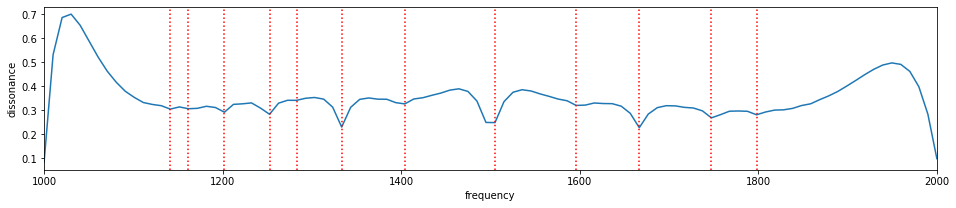

In [5]:

#freqs = d
freqs = freq_space(1000, 2, 100)
plot_dissonance_curve(freqs, dissonance_curve(freqs, n_partials=250, model='sethares1993'))

In [7]:
freqs

array([1000.        , 1010.1010101 , 1020.2020202 , 1030.3030303 ,
       1040.4040404 , 1050.50505051, 1060.60606061, 1070.70707071,
       1080.80808081, 1090.90909091, 1101.01010101, 1111.11111111,
       1121.21212121, 1131.31313131, 1141.41414141, 1151.51515152,
       1161.61616162, 1171.71717172, 1181.81818182, 1191.91919192,
       1202.02020202, 1212.12121212, 1222.22222222, 1232.32323232,
       1242.42424242, 1252.52525253, 1262.62626263, 1272.72727273,
       1282.82828283, 1292.92929293, 1303.03030303, 1313.13131313,
       1323.23232323, 1333.33333333, 1343.43434343, 1353.53535354,
       1363.63636364, 1373.73737374, 1383.83838384, 1393.93939394,
       1404.04040404, 1414.14141414, 1424.24242424, 1434.34343434,
       1444.44444444, 1454.54545455, 1464.64646465, 1474.74747475,
       1484.84848485, 1494.94949495, 1505.05050505, 1515.15151515,
       1525.25252525, 1535.35353535, 1545.45454545, 1555.55555556,
       1565.65656566, 1575.75757576, 1585.85858586, 1595.95959

# PyTuning

In [259]:
import pytuning as pt
import sympy as sp
from pytuning.scales import create_edo_scale
edo_12 = create_edo_scale(10)
edo_12


#x = pt.find_best_modes(harm_ratios[0], 7)
#x
#major_mask = (0,2,4,5,7,9,11,12)
#major_mode = mask_scale(edo_12_scale, major_mask)
#major_mode

[1,
 2**(1/10),
 2**(1/5),
 2**(3/10),
 2**(2/5),
 sqrt(2),
 2**(3/5),
 2**(7/10),
 2**(4/5),
 2**(9/10),
 2]

In [269]:
float(edo_12[7])

1.624504792712471

In [26]:
x = pt.find_best_modes(charm_fit, 3)
x


[{'scale': [1.0357142857142856, 1.25, 1.294642857142857, 2.0],
  'mask': (0, 1, 2, 11),
  'steps': [1, 1, 9],
  'original_scale': [1.0357142857142856,
   1.25,
   1.294642857142857,
   1.3571428571428572,
   1.430921052631579,
   1.4736842105263157,
   1.5,
   1.526315789473684,
   1.8750000000000002,
   1.9078947368421053,
   1.9419642857142856,
   2.0],
  'sum_p_q': 9,
  'sum_distinct_intervals': 14,
  'metric_3': 36.3939393939395,
  'sum_p_q_for_all_intervals': 34,
  'sum_q_for_all_intervals': 14}]

In [256]:
#This function is similar to the harmonic_tuning function built in BioTuning Package

from pytuning.scales import create_harmonic_scale
scale = create_harmonic_scale(1,20)
scale

h, i = harmonic_tuning(12, 2)
h



[1.0, 2.0, 1.75, 1.5, 1.25, 1.125, 1.375]

In [ ]:
#Computes ratios of the harmonic scale

harm_ratios = compute_peak_ratios(h)
harm_ratios[0]

In [ ]:
h = EEG_harmonics_mult(peaks, 12, 0)
h

In [258]:
z = pt.scales.create_equal_interval_scale(1.625, scale_size=10)
z

[1.0,
 1.07275390625000,
 1.14729876404888,
 1.23076923076923,
 1.32031250000000,
 1.41206001729093,
 1.51479289940828,
 1.625,
 1.73792002128114,
 1.86436049157943,
 2]

In [111]:
sorted(ratios_tet)

[1.0136432647705078,
 1.06787109375,
 1.125,
 1.20135498046875,
 1.265625,
 1.3515243530273438,
 1.423828125,
 1.5,
 1.601806640625,
 1.6875,
 1.802032470703125,
 1.8984375]

In [49]:
intervals     = [22, 5, 9, 15]
multiplicities = [1,1,1,1]
scale         = pt.scales.create_euler_fokker_scale(intervals, multiplicities)
scale

NameError: name 'pt' is not defined

In [162]:
3/2**(1/9)

2.7776241368618715

## PyAudio

In [ ]:
def notes2play(array, fund):
    scale2play = []
    scale2play = [fund*x for x in array]
    
    return scale2play
    

In [74]:
import pyaudio
import struct
import math

FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()


def data_for_freq(frequency: float, time: float = None):
    """get frames for a fixed frequency for a specified time or
    number of frames, if frame_count is specified, the specified
    time is ignored"""
    frame_count = int(RATE * time)

    remainder_frames = frame_count % RATE
    wavedata = []

    for i in range(frame_count):
        a = RATE / frequency  # number of frames per wave
        b = i / a
        # explanation for b
        # considering one wave, what part of the wave should this be
        # if we graph the sine wave in a
        # displacement vs i graph for the particle
        # where 0 is the beginning of the sine wave and
        # 1 the end of the sine wave
        # which part is "i" is denoted by b
        # for clarity you might use
        # though this is redundant since math.sin is a looping function
        # b = b - int(b)

        c = b * (2 * math.pi)
        # explanation for c
        # now we map b to between 0 and 2*math.PI
        # since 0 - 2*PI, 2*PI - 4*PI, ...
        # are the repeating domains of the sin wave (so the decimal values will
        # also be mapped accordingly,
        # and the integral values will be multiplied
        # by 2*PI and since sin(n*2*PI) is zero where n is an integer)
        d = math.sin(c) * 32767
        e = int(d)
        wavedata.append(e)

    for i in range(remainder_frames):
        wavedata.append(0)

    number_of_bytes = str(len(wavedata))  
    wavedata = struct.pack(number_of_bytes + 'h', *wavedata)

    return wavedata


def play(frequency: float, time: float):
    """
    play a frequency for a fixed time!
    """
    frames = data_for_freq(frequency, time)
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, output=True)
    stream.write(frames)
    stream.stop_stream()
    stream.close()


#if __name__ == "__main__":
    
    
        


In [ ]:
scale2play = notes2play(d, 100)
scale2play
for i in scale2play:
    play(i, 1)
    